# Time Series Forecasting Using LSTM in PyTorch

## Authors:

### Marc Rodriguez Rodriguez (NIA: 267283)
### Isaac Pérez Anguiano (NIA: 268275)

### **Imports**

In [1]:
# Mount Google Drive to access files
from google.colab import drive

# Import PyTorch for building neural networks
import torch
from torch import nn

# Data manipulation
import pandas as pd

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Math and numerical utilities
import math
import numpy as np

# Data preprocessing and model evaluation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.utils import resample
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    roc_auc_score,
    ConfusionMatrixDisplay
)

# File and path handling
import os

### **Prepare the data**

In [2]:
# Connect Google Drive to access files in Colab
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Set working directory to the project folder in Google Drive
final_project = '/content/drive/Shareddrives/UPF_DeepLearning_2025/Final Project/'
os.chdir(final_project)

In [4]:
# Map event labels to binary values: 0 for 'None', 1 for 'Storm'
def map_event(event):
    if 'None' in event:
        return 0
    else:
        return 1

In [5]:
# Load and clean weather data
file_path = 'data/weather_madrid_LEMD_1997_2015.csv'
df = pd.read_csv(file_path)
df.columns = df.columns.str.strip()  # Remove leading/trailing spaces in column names
df = df.drop(columns=['Precipitationmm', 'CET', 'Max Gust SpeedKm/h'])  # Drop unused columns
df['Events'] = df['Events'].fillna('None')  # Fill missing event data
df = df.dropna()  # Drop remaining rows with NaNs

# Check unique weather events and dataset shape
events = df['Events'].unique()
print(events)
print(df.shape)

# Simplify and group weather event labels
df['Events'] = df['Events'].apply(lambda x: 'Rain-Thunderstorm' if 'Rain' in x else x)
df['Events'] = df['Events'].apply(lambda x: 'Storm-Snow' if 'Thunderstorm' in x else x)
df['Events'] = df['Events'].apply(lambda x: 'Storm' if 'Snow' in x else x)

# Keep only 'None' and 'Storm' event categories
df = df[df['Events'].isin(['None', 'Storm'])]
events = df['Events'].unique()
print(events)
print(df.shape)

df['Events'] = df['Events'].apply(map_event)
print(df['Events'].value_counts())

# Separate features and encoded target variable
features = df.drop(columns=['Events'])
X = features.values

le = LabelEncoder()
Y = le.fit_transform(df['Events'].values)

# Check label encoding classes
print(le.classes_)

['None' 'Rain' 'Rain-Snow' 'Snow' 'Fog' 'Fog-Rain' 'Rain-Thunderstorm'
 'Thunderstorm' 'Rain-Hail-Thunderstorm' 'Fog-Thunderstorm' 'Tornado'
 'Fog-Rain-Thunderstorm' 'Fog-Rain-Snow' 'Fog-Snow'
 'Rain-Snow-Thunderstorm' 'Rain-Hail']
(5439, 20)
['None' 'Storm']
(5217, 20)
Events
0    3653
1    1564
Name: count, dtype: int64
[0 1]


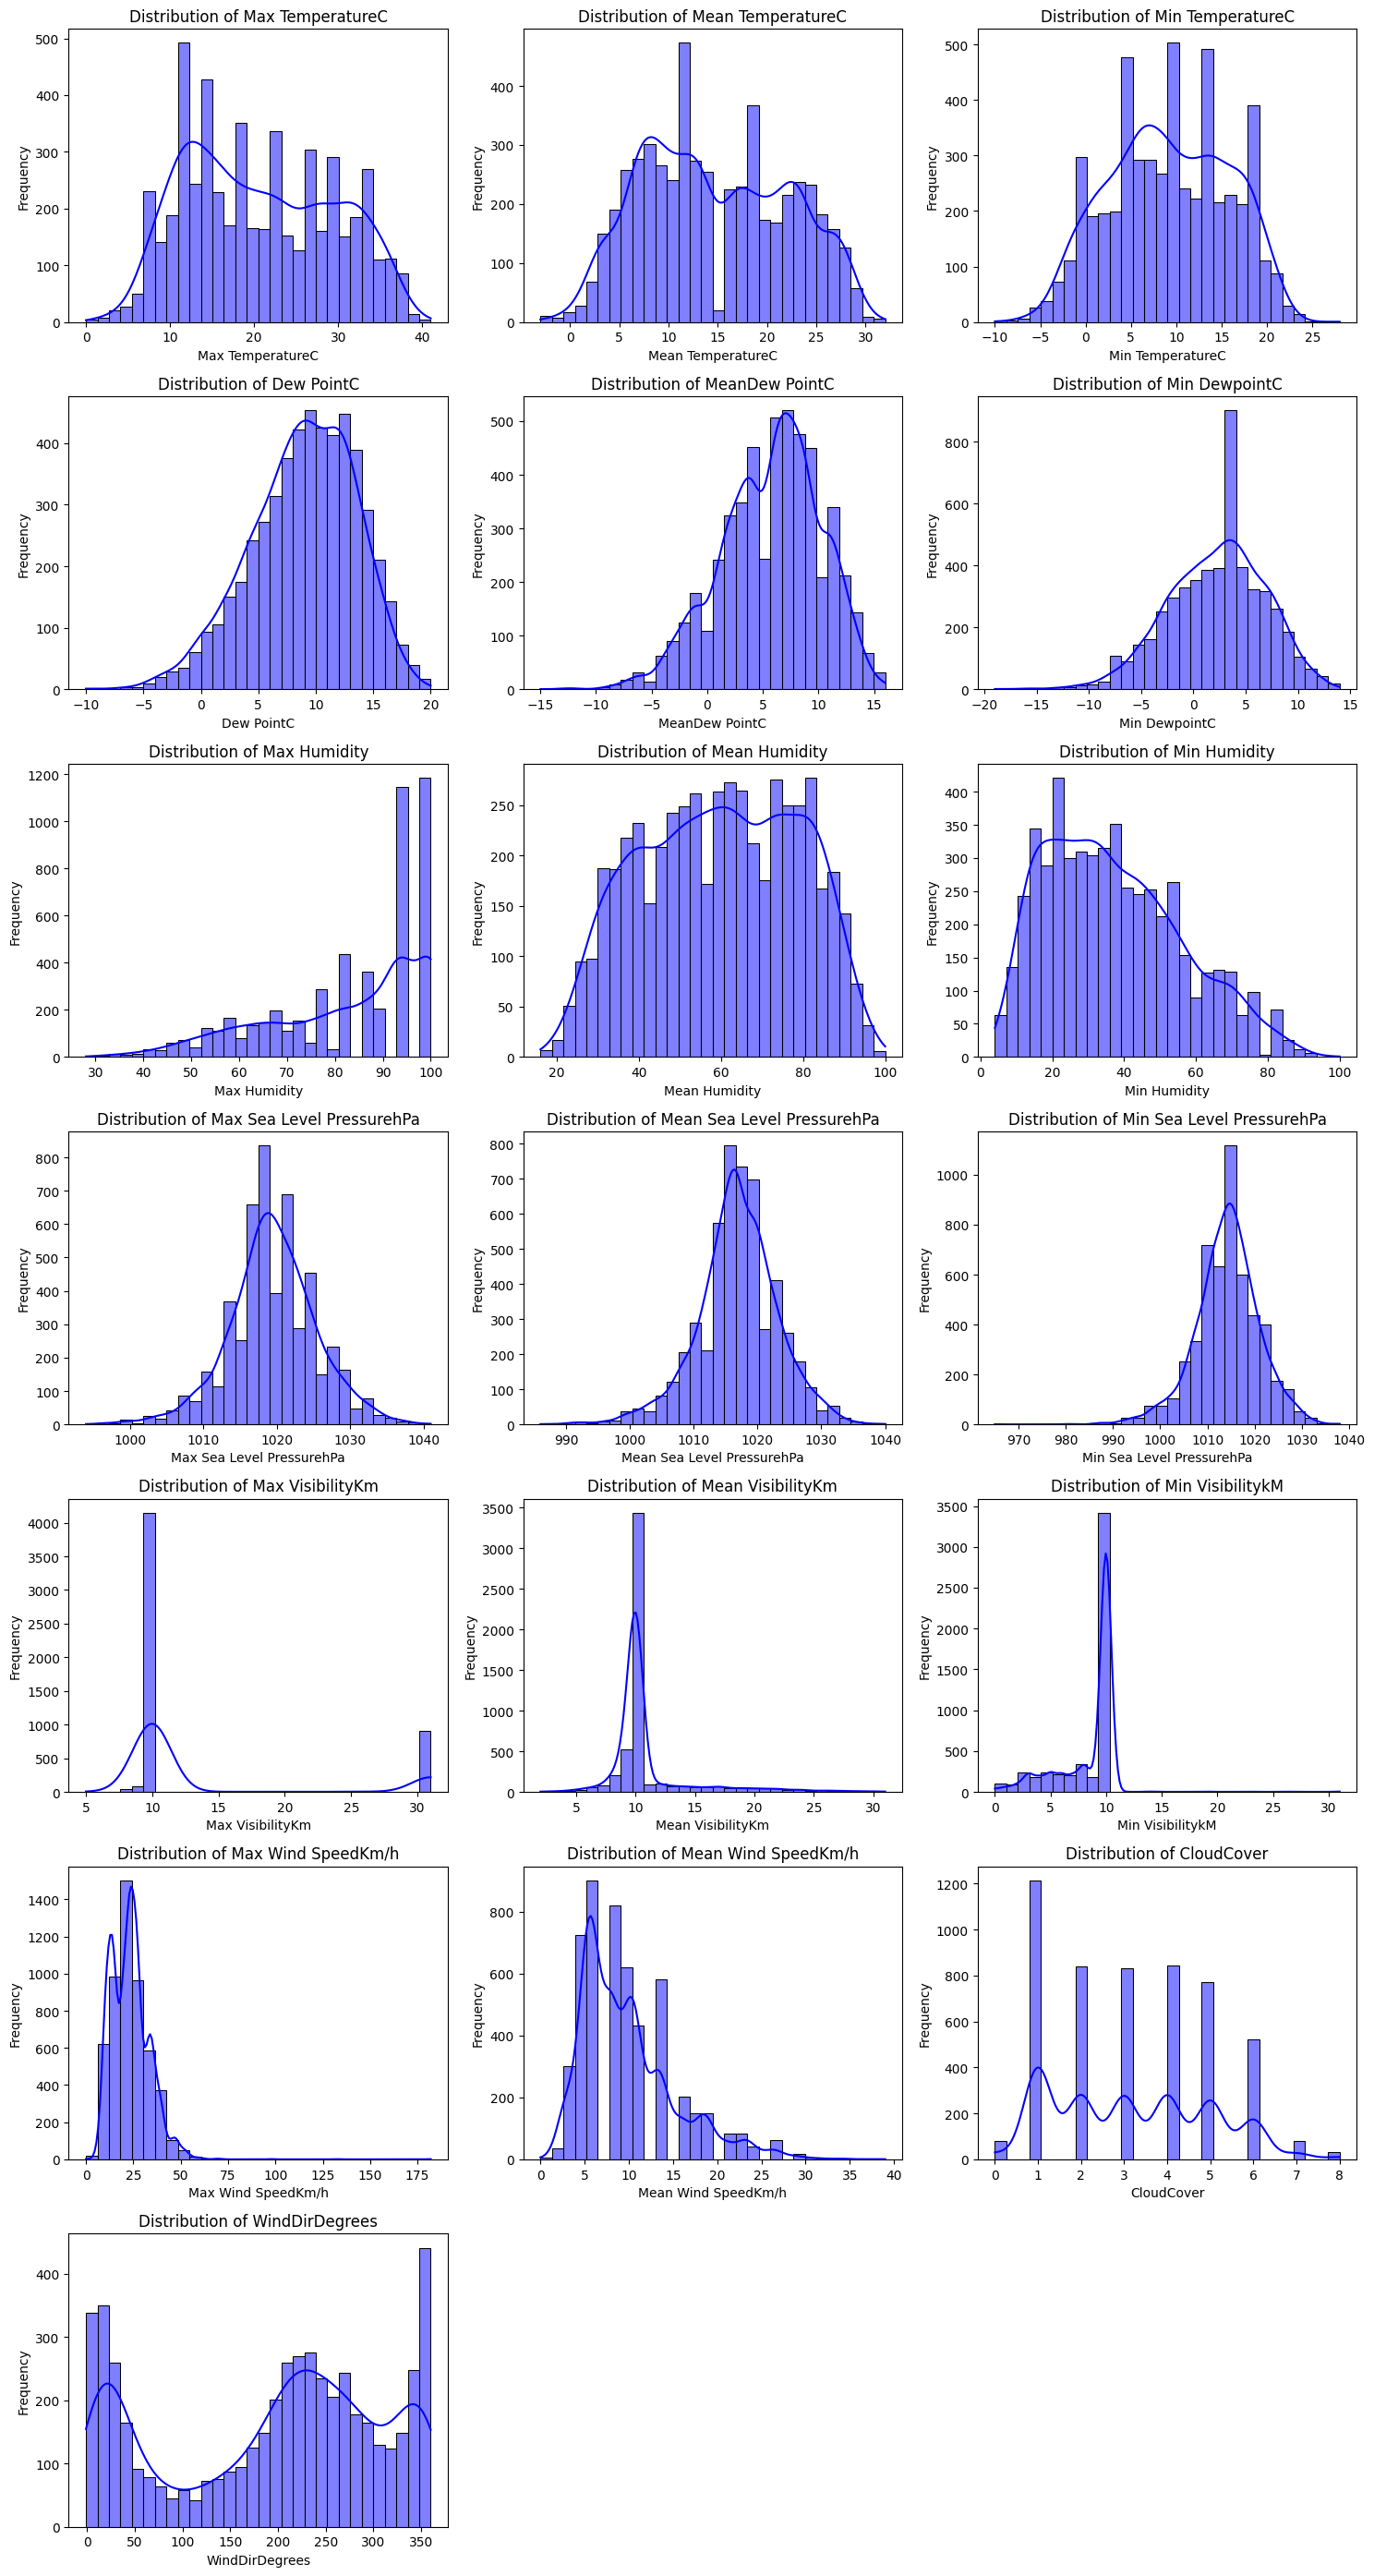

In [6]:
# Plot distribution of each feature
n_features = len(features.columns)
n_cols = 3
n_rows = math.ceil(n_features / n_cols)

plt.figure(figsize=(5 * n_cols, 4 * n_rows))  # Adjust figure size based on number of plots

for i, feature in enumerate(features.columns):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.histplot(df[feature].dropna(), kde=True, bins=30, color='blue')
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

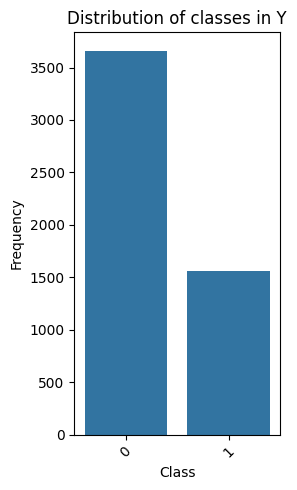

In [10]:
# Decode numerical labels back to original class names
y_labels = le.inverse_transform(Y)

# Create DataFrame for plotting class distribution
df_ylabels = pd.DataFrame({'Events': y_labels})

# Plot class distribution
plt.figure(figsize=(3, 5))
sns.countplot(data=df_ylabels, x='Events', order=df_ylabels['Events'].value_counts().index)
plt.xticks(rotation=45)
plt.title('Distribution of classes in Y')
plt.ylabel('Frequency')
plt.xlabel('Class')
plt.tight_layout()
plt.show()

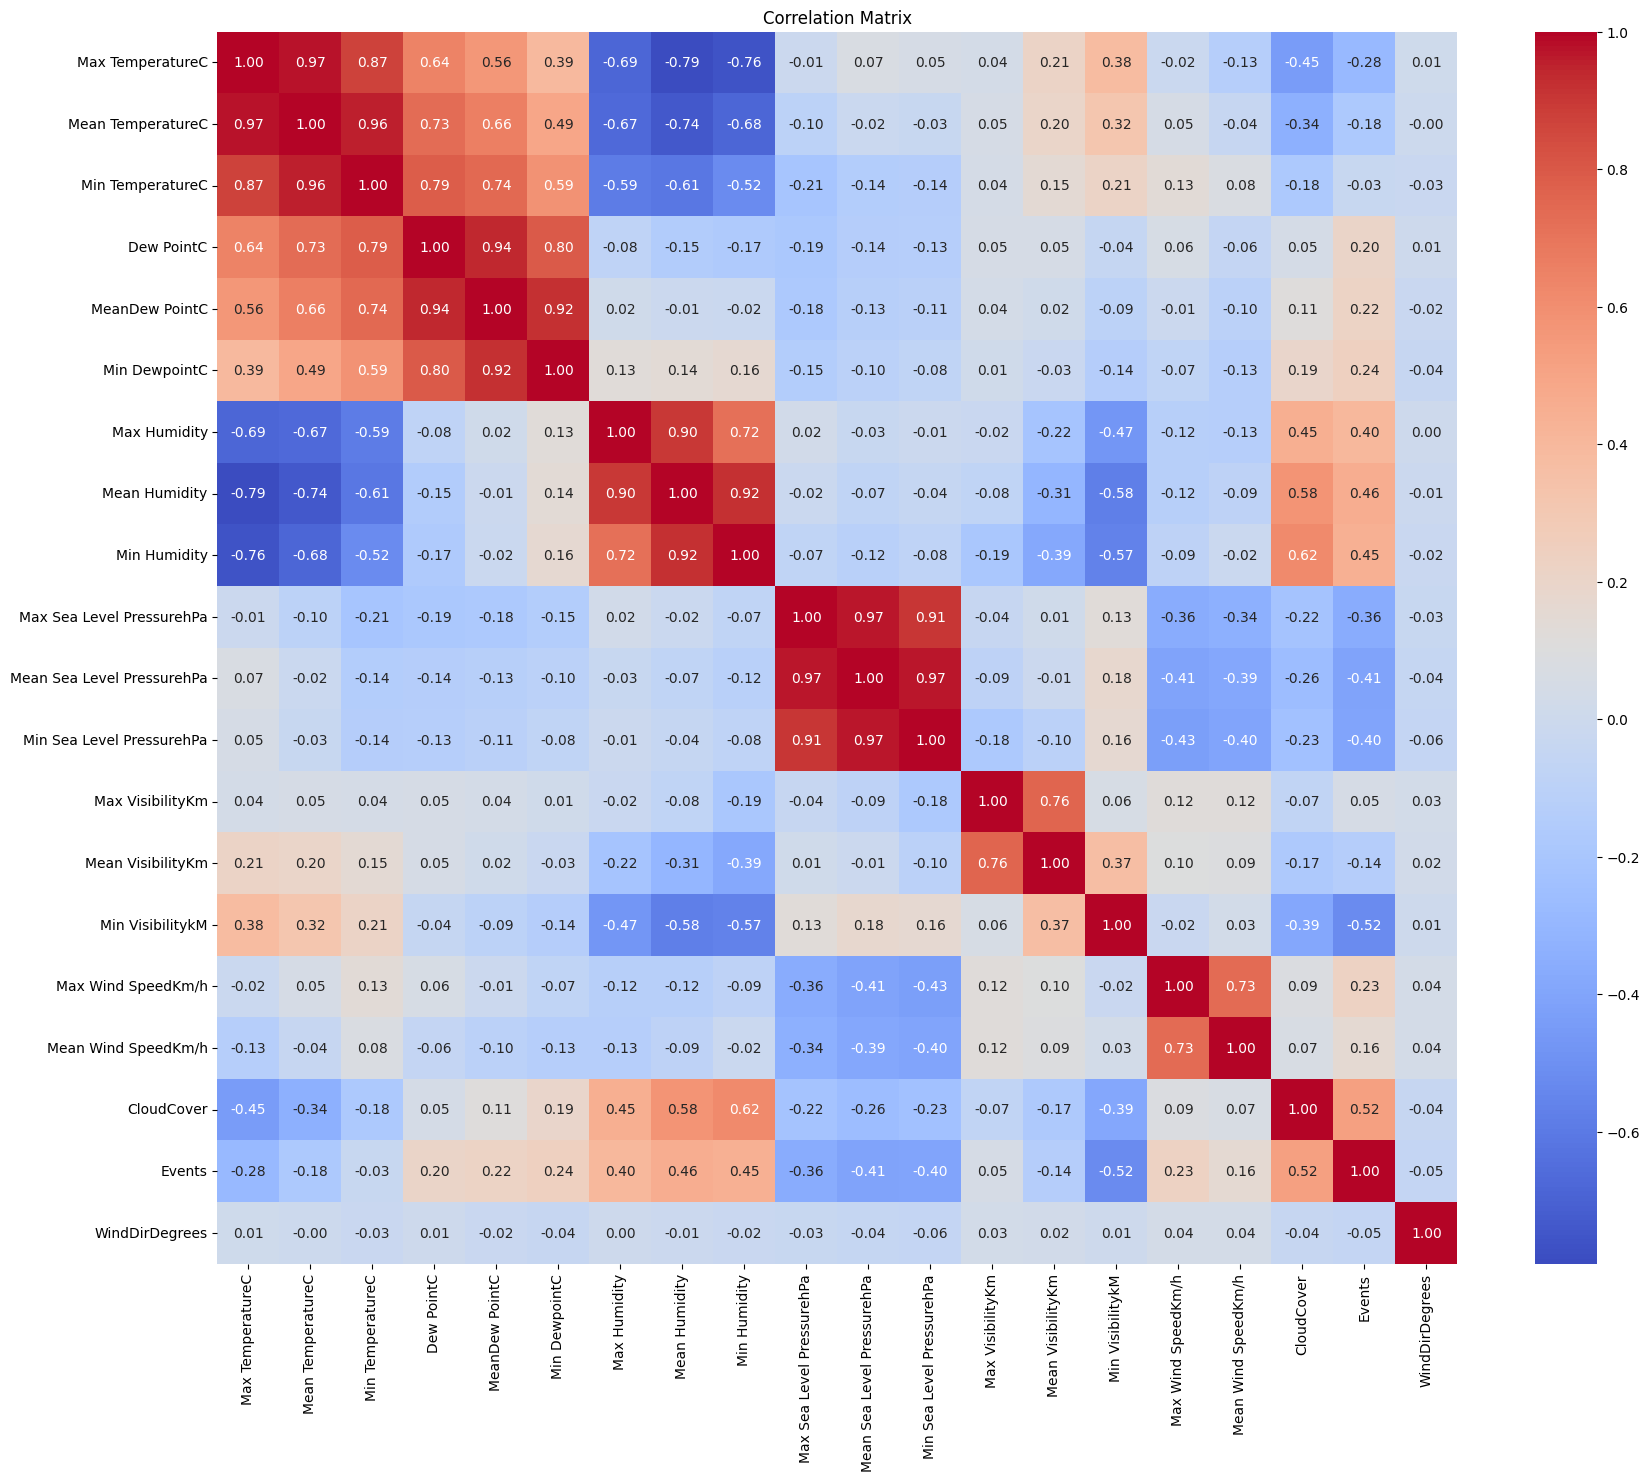

In [11]:
# Plot correlation matrix to analyze feature relationships
plt.figure(figsize=(20, 16))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

### **Prepare the data with selected features**

In [13]:
# Select relevant columns and read data
columns_to_keep = ['Max TemperatureC', 'Min DewpointC', 'Mean Humidity',
                   'Mean Sea Level PressurehPa', 'Min VisibilitykM',
                   'CloudCover', 'Events']
file_path = 'data/weather_madrid_LEMD_1997_2015.csv'

# Load and clean data
df = pd.read_csv(file_path)
df.columns = df.columns.str.strip()
df_clean = df[columns_to_keep].copy()
df_clean['Events'] = df_clean['Events'].fillna('None')
df_clean = df_clean.dropna()

# Group and simplify event labels
df_clean['Events'] = df_clean['Events'].apply(lambda x: 'Rain-Thunderstorm' if 'Rain' in x else x)
df_clean['Events'] = df_clean['Events'].apply(lambda x: 'Storm-Snow' if 'Thunderstorm' in x else x)
df_clean['Events'] = df_clean['Events'].apply(lambda x: 'Storm' if 'Snow' in x else x)

# Filter only 'None' and 'Storm' events
df_balanced = df_clean[df_clean['Events'].isin(['None', 'Storm'])].copy()

# Map events to binary labels
df_balanced['Events'] = df_balanced['Events'].apply(lambda e: 0 if e == 'None' else 1)

# Prepare features (X) and target (Y)
features = df_balanced.drop(columns=['Events'])
X = features.values

le = LabelEncoder()
Y = le.fit_transform(df_balanced['Events'].values)

# Scale 'Min VisibilitykM' column separately and combine with other features
col_to_scale = 'Min VisibilitykM'
X_col = features[[col_to_scale]].values
X_rest = features.drop(columns=[col_to_scale]).values

scaler = MinMaxScaler()
X_col_scaled = scaler.fit_transform(X_col)
X_scaled = np.concatenate([X_rest, X_col_scaled], axis=1)

# Summary of final dataset
print("Final class distribution:\n", df_balanced['Events'].value_counts())
print("Shape X:", X.shape, "Shape Y:", Y.shape)
display(df_balanced.head())

Final class distribution:
 Events
0    3653
1    1564
Name: count, dtype: int64
Shape X: (5217, 6) Shape Y: (5217,)


,Max TemperatureC,Min DewpointC,Mean Humidity,Mean Sea Level PressurehPa,Min VisibilitykM,CloudCover,Events
0,7.0,2.0,95.0,1008,4.0,6.0,0
1,7.0,0.0,92.0,1003,4.0,5.0,1
2,5.0,-1.0,85.0,999,7.0,6.0,1
3,7.0,-4.0,63.0,1010,10.0,2.0,0
4,2.0,-3.0,95.0,1008,1.0,7.0,1


### **Functions that helps to split the data and oversample the Strom class**

In [15]:
# Split time series data into training and testing sets based on a fixed ratio
def split_time_series_data(X, Y, train_ratio):
    # Total number of samples
    N = len(X)

    # Index where the training set ends
    train_end = int(N * train_ratio)

    # Perform the split while preserving order (no shuffling)
    X_train, Y_train = X[:train_end], Y[:train_end]
    X_test, Y_test = X[train_end:], Y[train_end:]

    return (X_train, Y_train), (X_test, Y_test)

    # Oversample the minority class in the training set to balance the class distribution
def oversample_minority_class(X_train, Y_train, target_class=1, n_samples=3000, random_state=42):
    # Temporarily combine features and labels for easier processing
    df_train = pd.DataFrame(X_train)
    df_train['label'] = Y_train

    # Separate majority and minority classes
    df_majority = df_train[df_train['label'] != target_class]
    df_minority = df_train[df_train['label'] == target_class]

    # Perform oversampling on the minority class
    df_minority_upsampled = resample(df_minority,
                                     replace=True,
                                     n_samples=n_samples,
                                     random_state=random_state)

    # Combine back and shuffle the dataset
    df_upsampled = pd.concat([df_majority, df_minority_upsampled])
    df_upsampled = df_upsampled.sample(frac=1, random_state=random_state)

    # Separate features and labels again
    X_train_bal = df_upsampled.drop(columns=['label']).values
    Y_train_bal = df_upsampled['label'].values

    return X_train_bal, Y_train_bal

### **Prepare the tensors**

In [16]:
# Split the scaled dataset into training and testing sets (80/20)
(X_train, Y_train), (X_test, Y_test) = split_time_series_data(X_scaled, Y, train_ratio=0.8)

# Oversample the 'Storm' class in the training set to balance class distribution
X_train, Y_train = oversample_minority_class(X_train, Y_train, target_class=1, n_samples=3000)

# Display shapes of the resulting datasets
print(f'Training set (balanced): {X_train.shape}, Labels: {Y_train.shape}')
print(f'Testing set: {X_test.shape}, Labels: {Y_test.shape}')

Training set (balanced): (5971, 6), Labels: (5971,)
Testing set: (1044, 6), Labels: (1044,)


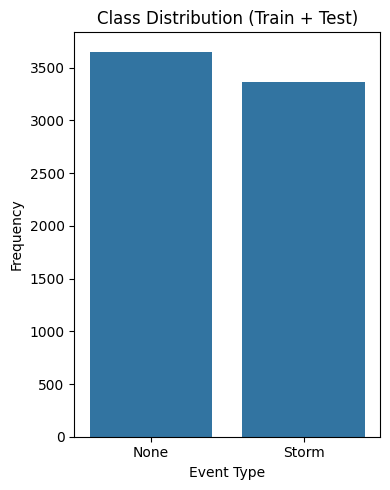

In [18]:
# Combine training and testing labels for full class distribution visualization
Y_total = np.concatenate([Y_train, Y_test])
label_map = {0: 'None', 1: 'Storm'}
y_labels_named = [label_map[y] for y in Y_total]

# Create DataFrame for plotting
df_total = pd.DataFrame({'Events': y_labels_named})

# Plot class distribution after oversampling
plt.figure(figsize=(4, 5))
sns.countplot(data=df_total, x='Events', order=['None', 'Storm'])
plt.title('Class Distribution (Train + Test)')
plt.xlabel('Event Type')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [24]:
# Set random seeds for reproducibility
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

# Convert input features to float32 tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor  = torch.tensor(X_test, dtype=torch.float32)

# Convert labels to float32 tensors (for binary classification with BCE loss)
Y_train_tensor = torch.tensor(Y_train, dtype=torch.float32)
Y_test_tensor  = torch.tensor(Y_test, dtype=torch.float32)

### **Prepare the model**

In [19]:
class SequenceClassifier(nn.Module):
    """
    A neural network module for classifying sequences using either an RNN or LSTM architecture.

    Attributes:
        use_lstm (bool): Flag to use LSTM if set to True; otherwise, RNN is used.
        rnn (nn.Module): The RNN or LSTM module for sequence processing.
        sigmoid (nn.Sigmoid): Sigmoid activation function for binary classification.
        last_linear (nn.Linear): Linear layer to map the hidden state to a single output.

    Parameters:
        input_size (int): The number of expected features in the input `x`.
        hidden_size (int): The number of features in the hidden state `h`.
        num_layers (int): Number of recurrent layers.
        use_lstm (bool): Whether to use LSTM (True) or RNN (False).

    Returns:
        A tensor of shape (batch_size, 1), where each element is the probability of the sequence being of class 1.
    """
    def __init__(self, input_size: int = 1, hidden_size: int = 5, num_layers: int = 1, use_lstm: bool = False):
        super(SequenceClassifier, self).__init__()

        self.use_lstm = use_lstm

        # Define the recurrent layer (LSTM or RNN)
        self.rnn = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                           num_layers=num_layers, batch_first=True) if use_lstm else \
                   nn.RNN(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True)

        # Final linear layer to map hidden state to output
        self.last_linear = nn.Linear(hidden_size, 1)

        # Sigmoid activation for binary output
        self.sigmoid = nn.Sigmoid()

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        """
        Forward pass for the sequence classifier.

        Parameters:
            X (torch.Tensor): The input tensor containing the features of the sequences with shape (batch_size, seq_length, input_size).

        Returns:
            torch.Tensor: The output tensor containing the predicted probability for each sequence with shape (batch_size, 1).
        """
        # Run input through RNN or LSTM
        _, last_states = self.rnn(X)

        # Get last hidden state from output (LSTM returns (h_n, c_n))
        last_hidden_state = last_states[0][-1] if self.use_lstm else last_states[-1]

        # Pass last hidden state through final linear + sigmoid
        output = self.last_linear(last_hidden_state)
        output = self.sigmoid(output)

        return output

### **Functions to test the models**

In [20]:
# Function to evaluate a sequence classifier on a test set
def test_sequence_classifier(
        X_test: torch.Tensor,
        Y_test: torch.Tensor,
        seq_classifier: nn.Module,
        loss_func: nn.Module) -> dict:
    """
    Test the sequence classifier using the provided testing dataset and calculate different evaluation metrics.

    Parameters:
        X_test (torch.Tensor): The input features for testing with shape (batch_size, seq_length, input_size).
        Y_test (torch.Tensor): The true labels for testing with shape (batch_size, 1).
        seq_classifier (nn.Module): The sequence classifier neural network.
        loss_func (nn.Module): Loss function used to calculate the testing set loss (e.g., nn.BCELoss).

    Returns:
        dict: Dictionary containing accuracy, precision, recall, F1 score, AUC-ROC, and confusion matrix.
    """
    torch.manual_seed(42)
    torch.cuda.manual_seed_all(42)

    seq_classifier.eval() # Set model to evaluation mode

    with torch.inference_mode():

        # Forward pass - model outputs probabilities
        probs = seq_classifier(X_test)
        # Predict labels based on a threshold (e.g., 0.5)
        predicted_labels = (probs > 0.5).long()
        true_labels = Y_test # Target shape is already (batch_size, 1)

        # Compute test loss
        loss = loss_func(probs, true_labels)

        # Move to CPU and flatten to 1D for metric calculations
        y_true = true_labels.cpu().numpy().flatten()
        y_pred = predicted_labels.cpu().numpy().flatten()
        y_probs = probs.cpu().numpy().flatten()

        # Compute metrics
        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, zero_division=0)
        recall = recall_score(y_true, y_pred, zero_division=0)
        f1 = f1_score(y_true, y_pred, zero_division=0)
        # AUC-ROC for binary classification with probabilities
        auc = roc_auc_score(y_true, y_probs)
        # Confusion matrix requires labels 0 and 1
        cm = confusion_matrix(y_true, y_pred, labels=[0, 1])

    # Print metrics
    print(f'Test loss: {loss.item():.4f}')
    print(f'Accuracy: {accuracy:.2%}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'AUC-ROC: {auc:.4f}')

    return {
        'loss': loss.item(),
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'auc_roc': auc,
        'confusion_matrix': cm
    }

### **Functions to train and evaluate the models**

In [22]:
# Function to train and evaluate a sequence classifier model
def train_and_evaluate_sequence_classifier(
        model: nn.Module,
        num_epochs: int,
        loss_fn,
        optimizer,
        X_train: torch.Tensor,
        Y_train: torch.Tensor,
        X_test: torch.Tensor,
        Y_test: torch.Tensor,
        use_cuda: bool = True
) -> tuple:
    """
    Train a sequence classifier and evaluate it on the test set.

    Returns:
        tuple: (trained model, train loss history, test loss history, accuracy history, final test metrics)
    """

    # Set random seed for reproducibility
    torch.manual_seed(42)
    torch.cuda.manual_seed_all(42)

    # Move model and data to GPU if available
    device = torch.device("cuda" if use_cuda and torch.cuda.is_available() else "cpu")
    model = model.to(device)
    X_train, Y_train = X_train.to(device), Y_train.to(device)
    X_test, Y_test = X_test.to(device), Y_test.to(device)

    # Initialize training history containers
    train_loss_hist = []
    test_loss_hist = []
    acc_hist = []

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()

        # Forward + backward + optimize
        outputs = model(X_train)
        train_loss = loss_fn(outputs, Y_train)
        train_loss.backward()
        optimizer.step()

        train_loss_hist.append(train_loss.item())

        # Evaluate on test set
        model.eval()
        with torch.no_grad():
            test_outputs = model(X_test)
            test_loss = loss_fn(test_outputs, Y_test)
            test_loss_hist.append(test_loss.item())

            preds = (test_outputs > 0.5).long()
            acc = (preds == Y_test).float().mean().item()
            acc_hist.append(acc)

        # Periodic logging
        if epoch % 50 == 0:
            print(f"Epoch {epoch} | Train Loss: {train_loss.item():.4f} | Test Loss: {test_loss.item():.4f} | Accuracy: {acc * 100:.2f}%")

    # Final epoch log
    print(f"Final Epoch | Train Loss: {train_loss.item():.4f} | Test Loss: {test_loss.item():.4f} | Accuracy: {acc * 100:.2f}%")

    # Evaluate complete test metrics
    metrics = test_sequence_classifier(X_test, Y_test, model, loss_fn)

    return model, train_loss_hist, test_loss_hist, acc_hist, metrics

### **Results of all the models that trains**

Usando dispositivo: cuda

Entrenando modelo: LSTM_h32_l1
Epoch 0 | Train Loss: 0.6919 | Test Loss: 0.6831 | Accuracy: 65.33%
Epoch 50 | Train Loss: 0.6600 | Test Loss: 0.6686 | Accuracy: 71.46%
Epoch 100 | Train Loss: 0.6431 | Test Loss: 0.6460 | Accuracy: 73.75%
Epoch 150 | Train Loss: 0.6292 | Test Loss: 0.6323 | Accuracy: 74.23%
Epoch 200 | Train Loss: 0.6167 | Test Loss: 0.6208 | Accuracy: 74.23%
Epoch 250 | Train Loss: 0.6053 | Test Loss: 0.6105 | Accuracy: 74.33%
Epoch 300 | Train Loss: 0.5949 | Test Loss: 0.6012 | Accuracy: 74.04%
Epoch 350 | Train Loss: 0.5853 | Test Loss: 0.5926 | Accuracy: 74.52%
Epoch 400 | Train Loss: 0.5763 | Test Loss: 0.5846 | Accuracy: 74.71%
Epoch 450 | Train Loss: 0.5679 | Test Loss: 0.5770 | Accuracy: 75.10%
Epoch 500 | Train Loss: 0.5598 | Test Loss: 0.5695 | Accuracy: 75.10%
Epoch 550 | Train Loss: 0.5520 | Test Loss: 0.5622 | Accuracy: 75.57%
Epoch 600 | Train Loss: 0.5444 | Test Loss: 0.5551 | Accuracy: 76.15%
Epoch 650 | Train Loss: 0.5372 | Tes

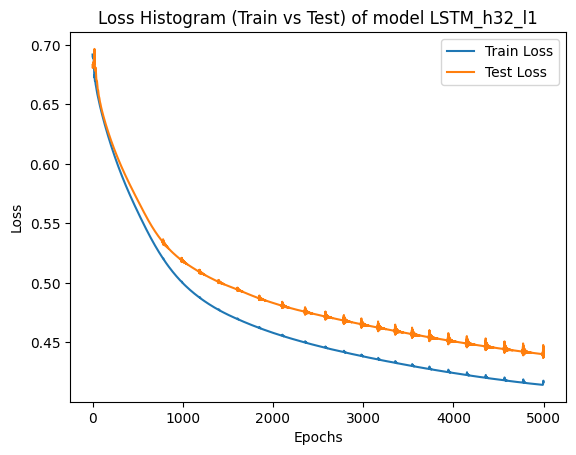

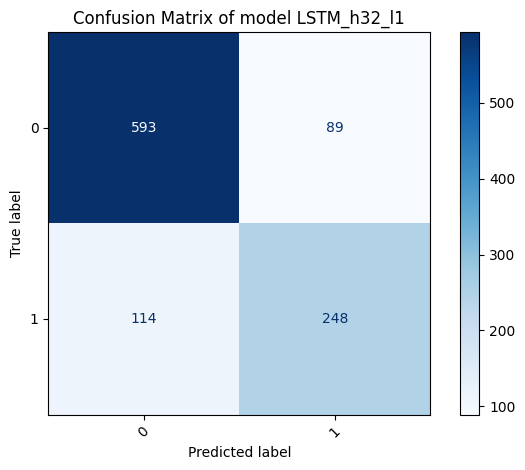


Entrenando modelo: LSTM_h32_l2
Epoch 0 | Train Loss: 0.6932 | Test Loss: 0.6998 | Accuracy: 34.67%
Epoch 50 | Train Loss: 0.6773 | Test Loss: 0.6784 | Accuracy: 71.17%
Epoch 100 | Train Loss: 0.6366 | Test Loss: 0.6372 | Accuracy: 73.37%
Epoch 150 | Train Loss: 0.5712 | Test Loss: 0.5758 | Accuracy: 74.23%
Epoch 200 | Train Loss: 0.5231 | Test Loss: 0.5379 | Accuracy: 73.95%
Epoch 250 | Train Loss: 0.4972 | Test Loss: 0.5113 | Accuracy: 75.19%
Epoch 300 | Train Loss: 0.4697 | Test Loss: 0.4947 | Accuracy: 76.92%
Epoch 350 | Train Loss: 0.4544 | Test Loss: 0.4885 | Accuracy: 76.92%
Epoch 400 | Train Loss: 0.4486 | Test Loss: 0.4850 | Accuracy: 76.72%
Epoch 450 | Train Loss: 0.4450 | Test Loss: 0.4807 | Accuracy: 76.72%
Epoch 500 | Train Loss: 0.4446 | Test Loss: 0.4775 | Accuracy: 76.82%
Epoch 550 | Train Loss: 0.4405 | Test Loss: 0.4778 | Accuracy: 76.63%
Epoch 600 | Train Loss: 0.4390 | Test Loss: 0.4761 | Accuracy: 76.92%
Epoch 650 | Train Loss: 0.4374 | Test Loss: 0.4761 | Accuracy

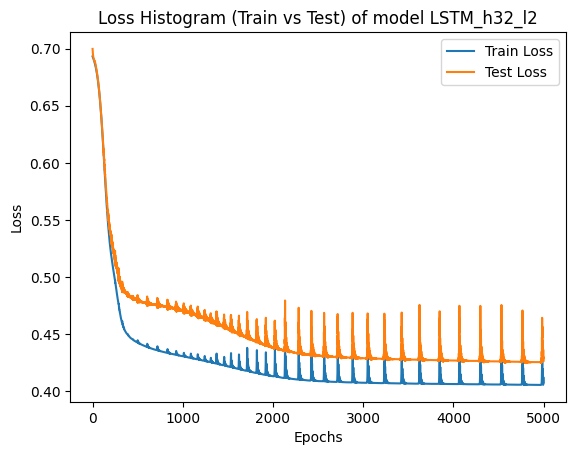

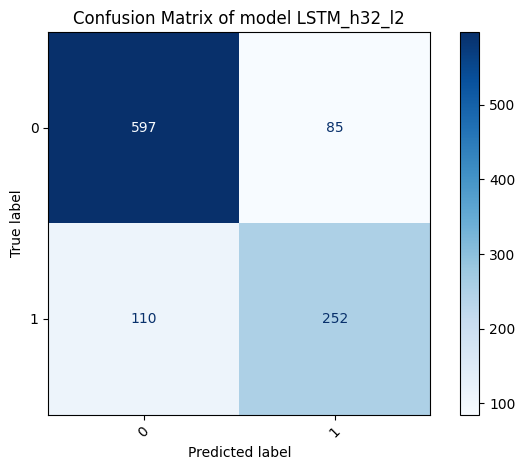


Entrenando modelo: LSTM_h32_l4
Epoch 0 | Train Loss: 0.6932 | Test Loss: 0.6934 | Accuracy: 34.67%
Epoch 50 | Train Loss: 0.6846 | Test Loss: 0.6849 | Accuracy: 71.17%
Epoch 100 | Train Loss: 0.5131 | Test Loss: 0.5247 | Accuracy: 74.23%
Epoch 150 | Train Loss: 0.4781 | Test Loss: 0.5010 | Accuracy: 75.67%
Epoch 200 | Train Loss: 0.4516 | Test Loss: 0.4895 | Accuracy: 76.92%
Epoch 250 | Train Loss: 0.4417 | Test Loss: 0.4764 | Accuracy: 77.49%
Epoch 300 | Train Loss: 0.4407 | Test Loss: 0.4724 | Accuracy: 77.20%
Epoch 350 | Train Loss: 0.4389 | Test Loss: 0.4687 | Accuracy: 77.78%
Epoch 400 | Train Loss: 0.4377 | Test Loss: 0.4665 | Accuracy: 78.07%
Epoch 450 | Train Loss: 0.4389 | Test Loss: 0.4672 | Accuracy: 77.97%
Epoch 500 | Train Loss: 0.4353 | Test Loss: 0.4613 | Accuracy: 78.35%
Epoch 550 | Train Loss: 0.4345 | Test Loss: 0.4594 | Accuracy: 78.54%
Epoch 600 | Train Loss: 0.4330 | Test Loss: 0.4573 | Accuracy: 78.93%
Epoch 650 | Train Loss: 0.4324 | Test Loss: 0.4552 | Accuracy

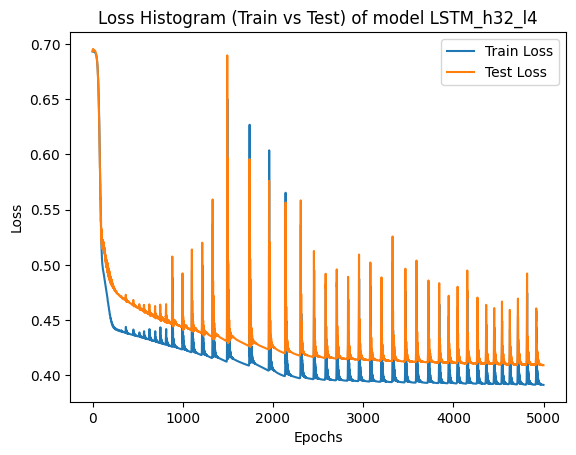

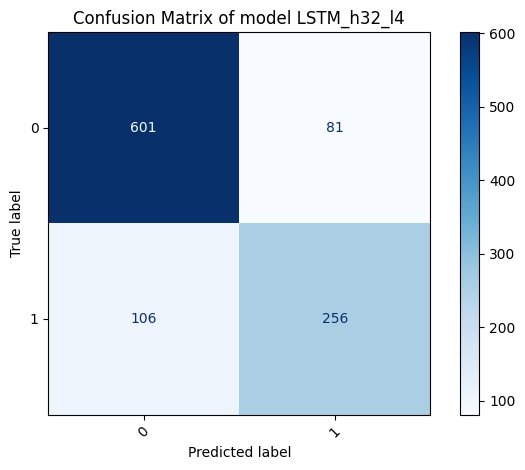


Entrenando modelo: LSTM_h64_l1
Epoch 0 | Train Loss: 0.6905 | Test Loss: 0.6697 | Accuracy: 65.33%
Epoch 50 | Train Loss: 0.6263 | Test Loss: 0.6089 | Accuracy: 74.81%
Epoch 100 | Train Loss: 0.5880 | Test Loss: 0.5814 | Accuracy: 74.23%
Epoch 150 | Train Loss: 0.5609 | Test Loss: 0.5610 | Accuracy: 74.43%
Epoch 200 | Train Loss: 0.5408 | Test Loss: 0.5463 | Accuracy: 74.14%
Epoch 250 | Train Loss: 0.5242 | Test Loss: 0.5339 | Accuracy: 74.62%
Epoch 300 | Train Loss: 0.5103 | Test Loss: 0.5177 | Accuracy: 76.53%
Epoch 350 | Train Loss: 0.4965 | Test Loss: 0.5109 | Accuracy: 76.25%
Epoch 400 | Train Loss: 0.4854 | Test Loss: 0.5018 | Accuracy: 77.30%
Epoch 450 | Train Loss: 0.4773 | Test Loss: 0.4982 | Accuracy: 76.92%
Epoch 500 | Train Loss: 0.4703 | Test Loss: 0.4904 | Accuracy: 77.68%
Epoch 550 | Train Loss: 0.4665 | Test Loss: 0.4900 | Accuracy: 76.92%
Epoch 600 | Train Loss: 0.4612 | Test Loss: 0.4841 | Accuracy: 77.20%
Epoch 650 | Train Loss: 0.4581 | Test Loss: 0.4831 | Accuracy

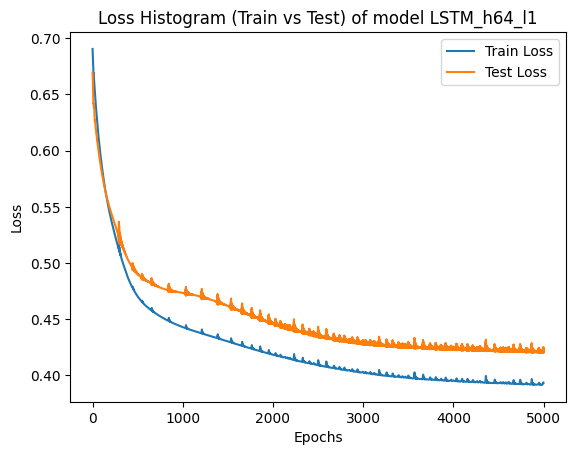

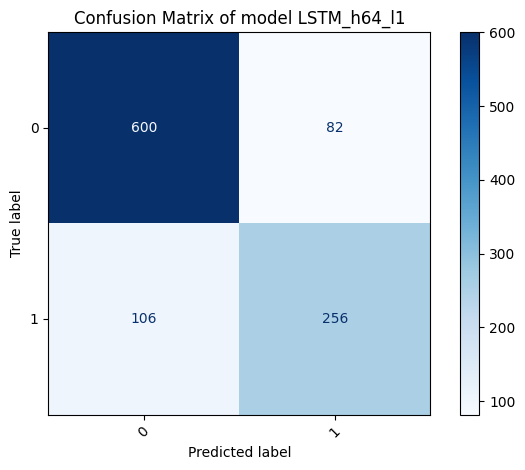


Entrenando modelo: LSTM_h64_l2
Epoch 0 | Train Loss: 0.6943 | Test Loss: 0.7081 | Accuracy: 34.67%
Epoch 50 | Train Loss: 0.6197 | Test Loss: 0.6164 | Accuracy: 72.61%
Epoch 100 | Train Loss: 0.5210 | Test Loss: 0.5312 | Accuracy: 74.23%
Epoch 150 | Train Loss: 0.4959 | Test Loss: 0.5163 | Accuracy: 74.62%
Epoch 200 | Train Loss: 0.4707 | Test Loss: 0.4924 | Accuracy: 76.44%
Epoch 250 | Train Loss: 0.4490 | Test Loss: 0.4884 | Accuracy: 77.39%
Epoch 300 | Train Loss: 0.4417 | Test Loss: 0.4823 | Accuracy: 77.30%
Epoch 350 | Train Loss: 0.4377 | Test Loss: 0.4804 | Accuracy: 77.68%
Epoch 400 | Train Loss: 0.4360 | Test Loss: 0.4791 | Accuracy: 77.87%
Epoch 450 | Train Loss: 0.4320 | Test Loss: 0.4724 | Accuracy: 78.45%
Epoch 500 | Train Loss: 0.4310 | Test Loss: 0.4686 | Accuracy: 78.64%
Epoch 550 | Train Loss: 0.4264 | Test Loss: 0.4658 | Accuracy: 78.64%
Epoch 600 | Train Loss: 0.4239 | Test Loss: 0.4623 | Accuracy: 79.12%
Epoch 650 | Train Loss: 0.4220 | Test Loss: 0.4622 | Accuracy

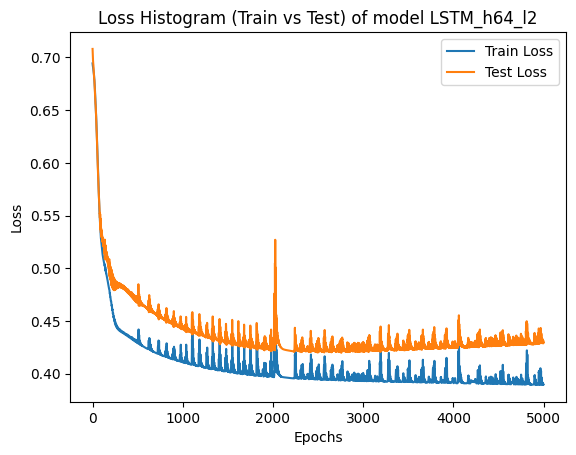

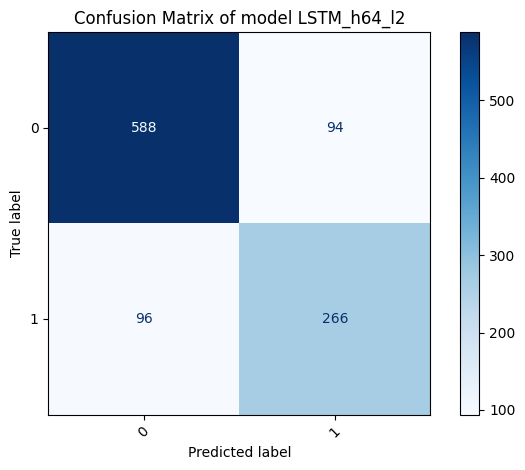


Entrenando modelo: LSTM_h64_l4
Epoch 0 | Train Loss: 0.6933 | Test Loss: 0.6896 | Accuracy: 65.33%
Epoch 50 | Train Loss: 0.5687 | Test Loss: 0.5787 | Accuracy: 73.95%
Epoch 100 | Train Loss: 0.4655 | Test Loss: 0.4943 | Accuracy: 76.82%
Epoch 150 | Train Loss: 0.4512 | Test Loss: 0.4797 | Accuracy: 77.49%
Epoch 200 | Train Loss: 0.4385 | Test Loss: 0.4708 | Accuracy: 78.07%
Epoch 250 | Train Loss: 0.4340 | Test Loss: 0.4664 | Accuracy: 78.07%
Epoch 300 | Train Loss: 0.4332 | Test Loss: 0.4639 | Accuracy: 78.26%
Epoch 350 | Train Loss: 0.4277 | Test Loss: 0.4635 | Accuracy: 78.74%
Epoch 400 | Train Loss: 0.4248 | Test Loss: 0.4546 | Accuracy: 78.93%
Epoch 450 | Train Loss: 0.4224 | Test Loss: 0.4525 | Accuracy: 79.21%
Epoch 500 | Train Loss: 0.4217 | Test Loss: 0.4513 | Accuracy: 79.50%
Epoch 550 | Train Loss: 0.4211 | Test Loss: 0.4535 | Accuracy: 79.50%
Epoch 600 | Train Loss: 0.4207 | Test Loss: 0.4540 | Accuracy: 79.60%
Epoch 650 | Train Loss: 0.4171 | Test Loss: 0.4468 | Accuracy

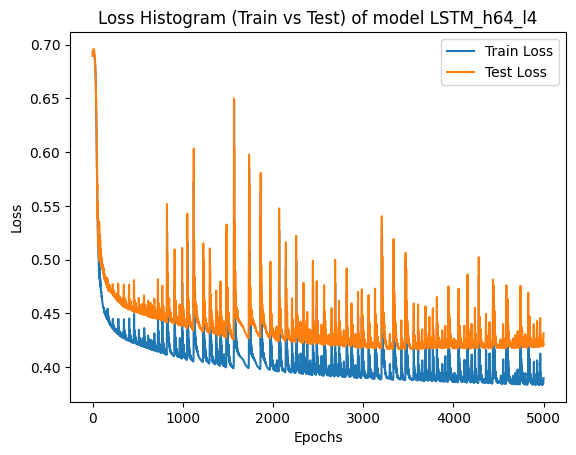

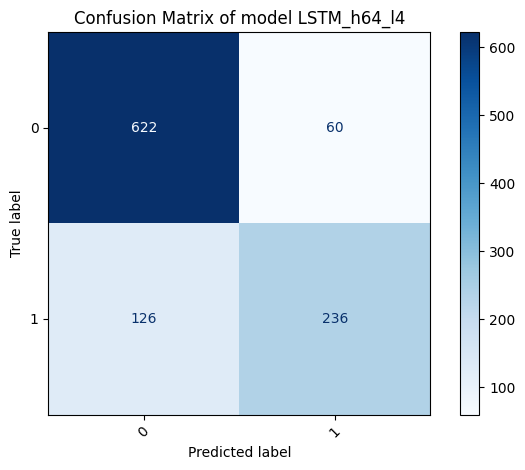


Entrenando modelo: LSTM_h128_l1
Epoch 0 | Train Loss: 0.7002 | Test Loss: 0.6851 | Accuracy: 65.23%
Epoch 50 | Train Loss: 0.6004 | Test Loss: 0.5974 | Accuracy: 73.18%
Epoch 100 | Train Loss: 0.5447 | Test Loss: 0.5510 | Accuracy: 73.56%
Epoch 150 | Train Loss: 0.5155 | Test Loss: 0.5291 | Accuracy: 74.43%
Epoch 200 | Train Loss: 0.4956 | Test Loss: 0.5203 | Accuracy: 74.71%
Epoch 250 | Train Loss: 0.4770 | Test Loss: 0.5024 | Accuracy: 75.86%
Epoch 300 | Train Loss: 0.4682 | Test Loss: 0.5007 | Accuracy: 75.86%
Epoch 350 | Train Loss: 0.4558 | Test Loss: 0.4831 | Accuracy: 77.59%
Epoch 400 | Train Loss: 0.4509 | Test Loss: 0.4796 | Accuracy: 77.01%
Epoch 450 | Train Loss: 0.4474 | Test Loss: 0.4767 | Accuracy: 77.30%
Epoch 500 | Train Loss: 0.4445 | Test Loss: 0.4741 | Accuracy: 77.30%
Epoch 550 | Train Loss: 0.4418 | Test Loss: 0.4713 | Accuracy: 77.30%
Epoch 600 | Train Loss: 0.4394 | Test Loss: 0.4694 | Accuracy: 77.39%
Epoch 650 | Train Loss: 0.4370 | Test Loss: 0.4666 | Accurac

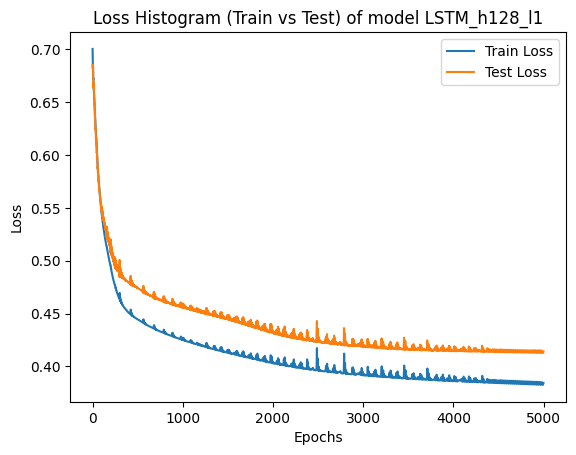

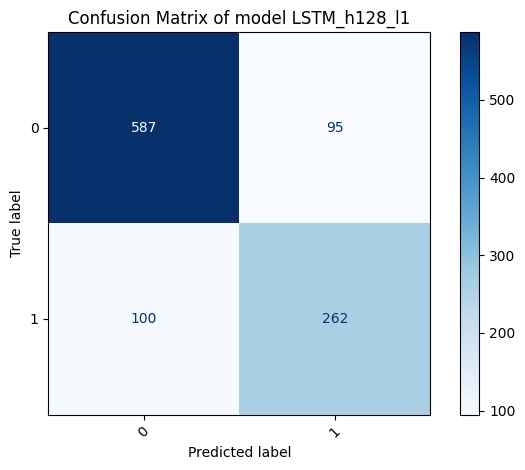


Entrenando modelo: LSTM_h128_l2
Epoch 0 | Train Loss: 0.6940 | Test Loss: 0.6959 | Accuracy: 34.67%
Epoch 50 | Train Loss: 0.5337 | Test Loss: 0.5409 | Accuracy: 74.14%
Epoch 100 | Train Loss: 0.4823 | Test Loss: 0.5023 | Accuracy: 75.48%
Epoch 150 | Train Loss: 0.4520 | Test Loss: 0.4819 | Accuracy: 77.59%
Epoch 200 | Train Loss: 0.4368 | Test Loss: 0.4798 | Accuracy: 77.78%
Epoch 250 | Train Loss: 0.4324 | Test Loss: 0.4819 | Accuracy: 77.59%
Epoch 300 | Train Loss: 0.4278 | Test Loss: 0.4798 | Accuracy: 77.87%
Epoch 350 | Train Loss: 0.4259 | Test Loss: 0.4807 | Accuracy: 77.39%
Epoch 400 | Train Loss: 0.4240 | Test Loss: 0.4743 | Accuracy: 78.26%
Epoch 450 | Train Loss: 0.4242 | Test Loss: 0.4697 | Accuracy: 78.07%
Epoch 500 | Train Loss: 0.4214 | Test Loss: 0.4721 | Accuracy: 79.31%
Epoch 550 | Train Loss: 0.4173 | Test Loss: 0.4669 | Accuracy: 78.83%
Epoch 600 | Train Loss: 0.4175 | Test Loss: 0.4647 | Accuracy: 79.41%
Epoch 650 | Train Loss: 0.4140 | Test Loss: 0.4628 | Accurac

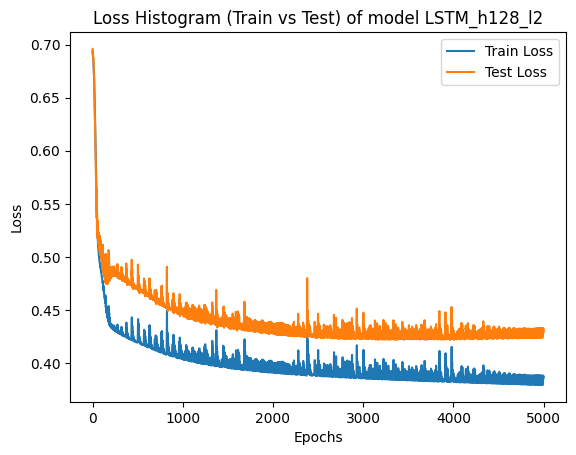

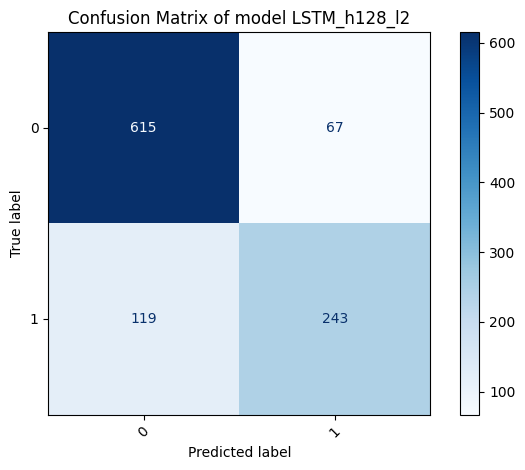


Entrenando modelo: LSTM_h128_l4
Epoch 0 | Train Loss: 0.6934 | Test Loss: 0.6885 | Accuracy: 65.33%
Epoch 50 | Train Loss: 0.5005 | Test Loss: 0.5274 | Accuracy: 74.62%
Epoch 100 | Train Loss: 0.4662 | Test Loss: 0.4981 | Accuracy: 75.77%
Epoch 150 | Train Loss: 0.4398 | Test Loss: 0.4799 | Accuracy: 77.39%
Epoch 200 | Train Loss: 0.4430 | Test Loss: 0.5095 | Accuracy: 76.92%
Epoch 250 | Train Loss: 0.4316 | Test Loss: 0.4803 | Accuracy: 77.87%
Epoch 300 | Train Loss: 0.4302 | Test Loss: 0.4813 | Accuracy: 77.87%
Epoch 350 | Train Loss: 0.4581 | Test Loss: 0.5391 | Accuracy: 75.38%
Epoch 400 | Train Loss: 0.4268 | Test Loss: 0.4750 | Accuracy: 78.35%
Epoch 450 | Train Loss: 0.4323 | Test Loss: 0.4709 | Accuracy: 78.16%
Epoch 500 | Train Loss: 0.4309 | Test Loss: 0.4898 | Accuracy: 78.07%
Epoch 550 | Train Loss: 0.4218 | Test Loss: 0.4706 | Accuracy: 78.83%
Epoch 600 | Train Loss: 0.4209 | Test Loss: 0.4714 | Accuracy: 78.45%
Epoch 650 | Train Loss: 0.4231 | Test Loss: 0.4716 | Accurac

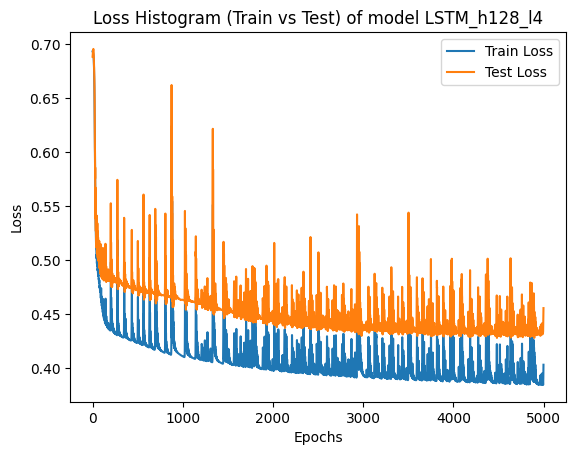

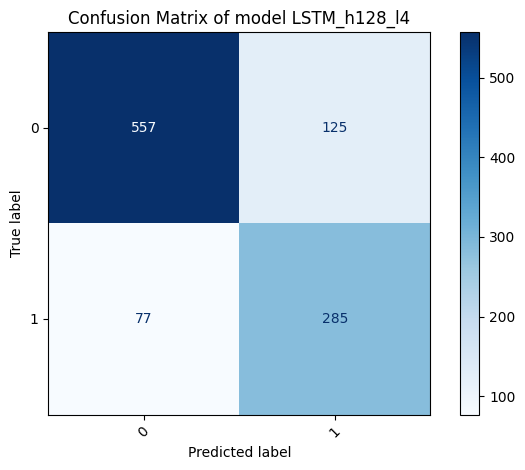

In [25]:
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

# Select device (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

# Prepare input tensors: add sequence dimension and move to device
X_train_seq = X_train_tensor.unsqueeze(1).to(device)  # (N, 1, 12)
X_test_seq  = X_test_tensor.unsqueeze(1).to(device)

# Prepare target tensors: add feature dimension and move to device
Y_train_tensor = Y_train_tensor.unsqueeze(1).to(device)  # (N, 1)
Y_test_tensor  = Y_test_tensor.unsqueeze(1).to(device)   # (N, 1)

# Define hyperparameter sets for model tuning
hidden_sizes = [32, 64, 128]
num_layers_list = [1, 2, 4]

results = {}
loss_fn = nn.BCELoss()

# Loop over hyperparameter combinations to train and evaluate models
for hidden_size in hidden_sizes:
    for num_layers in num_layers_list:
        name = f"LSTM_h{hidden_size}_l{num_layers}"
        print(f"\nEntrenando modelo: {name}")

        # Initialize the LSTM model with given parameters
        model = SequenceClassifier(input_size=6, hidden_size=hidden_size, num_layers=num_layers, use_lstm=True)

        # Setup optimizer for training
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

        # Train model and collect training history and metrics
        trained_model, train_loss_hist, test_loss_hist, acc_hist, metrics = train_and_evaluate_sequence_classifier(
            model=model,
            num_epochs=5000,
            loss_fn=loss_fn,
            optimizer=optimizer,
            X_train=X_train_seq,
            Y_train=Y_train_tensor,
            X_test=X_test_seq,
            Y_test=Y_test_tensor
        )

        # Store trained model and training results
        results[name] = {
            "model": trained_model,
            "train_loss": train_loss_hist,
            "test_loss": test_loss_hist,
            "accuracy": acc_hist
        }

        print(f"Modelo {name} completado. Última precisión: {acc_hist[-1]:.4f}")

        # Plot training vs testing loss curves
        plt.plot(train_loss_hist, label='Train Loss')
        plt.plot(test_loss_hist, label='Test Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title(f'Loss Histogram (Train vs Test) of model {name}')
        plt.legend()
        plt.show()

        # Plot confusion matrix for the model's performance
        disp = ConfusionMatrixDisplay(confusion_matrix=metrics['confusion_matrix'])
        disp.plot(cmap="Blues", xticks_rotation=45)
        plt.title(f"Confusion Matrix of model {name}")
        plt.tight_layout()
        plt.show()